In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pylab import savefig

In [22]:
from sklearn.model_selection import train_test_split
import pandas as pd

## IMporting the dataset from sklearn

In [8]:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
data_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

## data preprocessing and splitting

In [11]:

news = data_train.data
labels = data_train.target

X_train, y_train, X_test, y_test = train_test_split(news,labels, test_size = 0.20, random_state = 42)


In [13]:
vocab_size = 50000
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [16]:
embedding_dim = 128
max_length = 200

In [18]:
train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding='post', truncating='post')

validation_seq = tokenizer.texts_to_sequences(y_train)
validation_padded = pad_sequences(validation_seq, maxlen=max_length, padding='post', truncating='post')

In [23]:
training_labels = pd.get_dummies(X_test)
validation_labels = pd.get_dummies(y_test)

### MODEL

In [35]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

model.add(Conv1D(48, 5, activation='relu', padding='valid'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


## TRAINING OF THE MODEL

In [26]:
training_labels = training_labels.to_numpy()
validation_labels = validation_labels.to_numpy()

In [38]:
epochs = 20
batch_size = 32
history = model.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001), 
                               EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1),
                               EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1)])

Epoch 1/20
46/46 [==============================] - 5s 113ms/step - loss: 0.2647 - accuracy: 0.8345 - val_loss: 0.2228 - val_accuracy: 0.9114 - lr: 0.0010
Epoch 2/20
46/46 [==============================] - 5s 112ms/step - loss: 0.2206 - accuracy: 0.8788 - val_loss: 0.1918 - val_accuracy: 0.9169 - lr: 0.0010
Epoch 3/20
46/46 [==============================] - 5s 113ms/step - loss: 0.1878 - accuracy: 0.9010 - val_loss: 0.1684 - val_accuracy: 0.9280 - lr: 0.0010
Epoch 4/20
46/46 [==============================] - 5s 113ms/step - loss: 0.1584 - accuracy: 0.9162 - val_loss: 0.1518 - val_accuracy: 0.9280 - lr: 0.0010
Epoch 5/20
46/46 [==============================] - 5s 115ms/step - loss: 0.1363 - accuracy: 0.9301 - val_loss: 0.1383 - val_accuracy: 0.9280 - lr: 0.0010
Epoch 6/20
46/46 [==============================] - 5s 112ms/step - loss: 0.1192 - accuracy: 0.9474 - val_loss: 0.1305 - val_accuracy: 0.9307 - lr: 0.0010
Epoch 7/20
46/46 [==============================] - 5s 113ms/step - lo

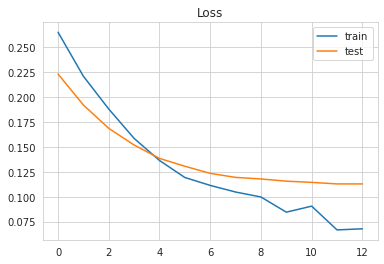

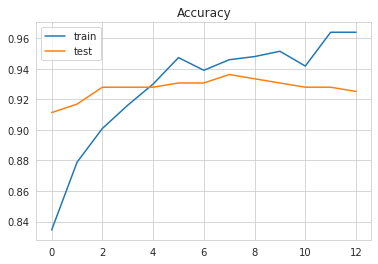

In [42]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## PREDICATION NAD ACCURACY

In [43]:
def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

# Now we make predictions using the test data to see how the model performs

predicted = model.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 96.24%
Precision: 0.96
Recall: 0.96
F1 score: 0.96


{'accuracy': 0.96, 'f1': 0.96, 'precision': 0.96, 'recall': 0.96}